In [1]:
# two layers type
# equal weight
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# The main AI trained on all the data of the new simulation
model_name = 'model-lsr'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .2, 
                 weight_compton=1, weight_non_compton=1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 1.4
ai.weight_pos_x = 2.5
ai.weight_pos_y = .5
ai.weight_pos_z = 2
ai.weight_energy = .8
ai.weight_e_cluster = .6
ai.weight_p_cluster = .4

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0000, limbs_l2=.0000)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [5]:
# compile the ai
ai.compile_model(learning_rate=0.003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .003
    elif epoch < 110:
        return .001
    elif epoch < 140:
        return .0003
    elif epoch < 165:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [6]:
# #LOADING
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [ ]:
#TRAINING

In [7]:
%%time
# balance the training data since there are too many background events
ai.data.balance_training = True

# start the training
ai.train(epochs=200, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

5209/5209 [==============================] - 10s 2ms/step - loss: 5.3522 - e_cluster_loss: 0.0373 - p_cluster_loss: 0.1416 - type_loss: 0.3968 - pos_x_loss: 0.1986 - pos_y_loss: 3.4682 - pos_z_loss: 0.1093 - energy_loss: 2.8355 - e_cluster__cluster_accuracy: 0.9707 - p_cluster__cluster_accuracy: 0.8835 - type__type_accuracy: 0.8251 - type__type_tp_rate: 0.8740

CPU times: user 17.7 s, sys: 1.23 s, total: 18.9 s
Wall time: 12 s


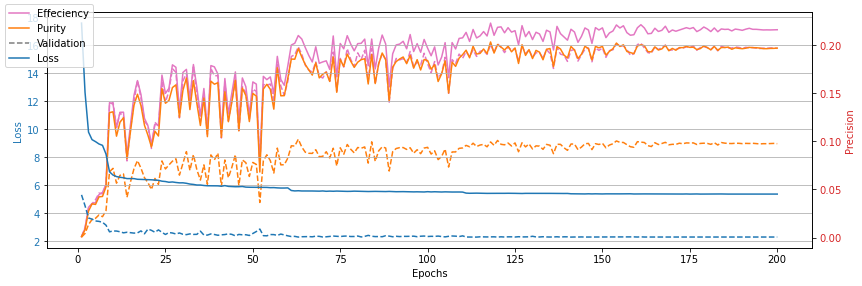

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [9]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        2.32029
    -Type:         0.42605 *  1.40 = 0.59647
    -Pos X:        0.06561 *  2.50 = 0.16403
    -Pos Y:        1.18301 *  0.50 = 0.59150
    -Pos Z:        0.03803 *  2.00 = 0.07605
    -Energy:       1.06418 *  0.80 = 0.85135
    -Cls e:        0.02912 *  0.60 = 0.01747
    -Cls p:        0.05853 *  0.40 = 0.02341
  Accuracy:     0.78940
    -Precision:    0.43446
    -Recall:       0.86348
    -Cls e rate:   0.95257
    -Cls p rate:   0.87022
  Efficiency:   0.19587
  Purity:       0.09855
  Euc mean:    10.58595
  Euc std:     17.70520
  Energy mean:  0.34024
  Energy std:   0.79382

Reco
  Accuracy:     0.66023
    -Recall:       0.76769
  Efficiency:   0.13425
  Purity:       0.05225
  Euc mean:    11.82275
  Euc std:     19.30429
  Energy mean:  0.50111
  Energy std:   1.01502


In [7]:
# evaluate the AI on a higher threshold to get better selection and purity
ai.type_threshold = .8
ai.evaluate()

AI model
  Loss:        2.32029
    -Type:         0.42605 *  1.40 = 0.59647
    -Pos X:        0.06561 *  2.50 = 0.16403
    -Pos Y:        1.18301 *  0.50 = 0.59150
    -Pos Z:        0.03803 *  2.00 = 0.07605
    -Energy:       1.06418 *  0.80 = 0.85135
    -Cls e:        0.02912 *  0.60 = 0.01747
    -Cls p:        0.05853 *  0.40 = 0.02341
  Accuracy:     0.78940
    -Precision:    0.56941
    -Recall:       0.56584
    -Cls e rate:   0.95257
    -Cls p rate:   0.87022
  Efficiency:   0.12713
  Purity:       0.12793
  Euc mean:    10.95862
  Euc std:     16.90406
  Energy mean:  0.27303
  Energy std:   0.69080

Reco
  Accuracy:     0.66023
    -Recall:       0.76769
  Efficiency:   0.13425
  Purity:       0.05225
  Euc mean:    11.82275
  Euc std:     19.30429
  Energy mean:  0.50111
  Energy std:   1.01502


In [10]:
ai.type_threshold = .85
ai.evaluate()

AI model
  Loss:        2.32029
    -Type:         0.42605 *  1.40 = 0.59647
    -Pos X:        0.06561 *  2.50 = 0.16403
    -Pos Y:        1.18301 *  0.50 = 0.59150
    -Pos Z:        0.03803 *  2.00 = 0.07605
    -Energy:       1.06418 *  0.80 = 0.85135
    -Cls e:        0.02912 *  0.60 = 0.01747
    -Cls p:        0.05853 *  0.40 = 0.02341
  Accuracy:     0.78940
    -Precision:    0.61019
    -Recall:       0.40202
    -Cls e rate:   0.95257
    -Cls p rate:   0.87022
  Efficiency:   0.08652
  Purity:       0.13132
  Euc mean:    11.30150
  Euc std:     16.65385
  Energy mean:  0.24956
  Energy std:   0.66387

Reco
  Accuracy:     0.66023
    -Recall:       0.76769
  Efficiency:   0.13425
  Purity:       0.05225
  Euc mean:    11.82275
  Euc std:     19.30429
  Energy mean:  0.50111
  Energy std:   1.01502


In [10]:
# save the trained model
ai.save(file_name=model_name)